**Problème 2**

Bloc 1 (Collecte de données) : Importe les données des portefeuilles sectoriels (10 Industries) et des facteurs Fama-French 5 depuis la bibliothèque famafrench.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets

datasets = get_available_datasets()
print([d for d in datasets if "Industry" in d][:5])

industries = web.DataReader("10_Industry_Portfolios", "famafrench")[0] / 100
ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench")[0] / 100

print("Industries (head):")
print(industries.head(), "\n")

print("Facteurs FF5 (head):")
print(ff5.head())


['5_Industry_Portfolios', '5_Industry_Portfolios_Wout_Div', '5_Industry_Portfolios_daily', '10_Industry_Portfolios', '10_Industry_Portfolios_Wout_Div']
Industries (head):
          NoDur   Durbl   Manuf   Enrgy   HiTec   Telcm   Shops    Hlth  \
Date                                                                      
2020-11  0.1002  0.3390  0.1396  0.2853  0.1072  0.1447  0.0830  0.0983   
2020-12  0.0491  0.1539  0.0252  0.0569  0.0508  0.0512  0.0138  0.0471   
2021-01 -0.0415  0.1148 -0.0232  0.0505  0.0056 -0.0355 -0.0006  0.0342   
2021-02  0.0132 -0.0808  0.0553  0.2362  0.0136  0.0426 -0.0165 -0.0125   
2021-03  0.0728  0.0087  0.0771  0.0228  0.0087  0.0163  0.0573 -0.0009   

          Utils   Other  
Date                     
2020-11  0.0266  0.1588  
2020-12  0.0062  0.0567  
2021-01 -0.0044 -0.0272  
2021-02 -0.0459  0.0979  
2021-03  0.1039  0.0526   

Facteurs FF5 (head):
         Mkt-RF     SMB     HML     RMW     CMA      RF
Date                                      

Bloc 2 (Préparation du DataFrame) : Crée le DataFrame df requis en sélectionnant HiTec comme variable dépendante (première colonne) et en combinant les 5 facteurs comme régresseurs.

In [2]:
# 1. Sélectionner une variable dépendante 'HiTec'
dependent_variable = industries[['HiTec']]

# 2. Combiner la variable dépendante avec les facteurs FF5
# S'assurer que le DataFrames sont alignés sur la date (l'index)
# On exclut le facteur RF (Taux sans risque) car les industries sont déjà en excès de rendement (Rit - RF)
# et les facteurs (Mkt-RF) sont déjà en excès de rendement.
df = dependent_variable.join(ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])

# Vérification de la structure du DataFrame
print("\nDataFrame final 'df' pour le problème 2a (head):")
print(df.head())
print("\nStructure des colonnes de 'df':")
print(df.columns)


DataFrame final 'df' pour le problème 2a (head):
          HiTec  Mkt-RF     SMB     HML     RMW     CMA
Date                                                   
2020-11  0.1072  0.1244  0.0712  0.0209 -0.0225  0.0128
2020-12  0.0508  0.0463  0.0493 -0.0168 -0.0197 -0.0006
2021-01  0.0056 -0.0007  0.0681  0.0322 -0.0365  0.0497
2021-02  0.0136  0.0281  0.0450  0.0720  0.0033 -0.0199
2021-03  0.0087  0.0316 -0.0084  0.0735  0.0635  0.0352

Structure des colonnes de 'df':
Index(['HiTec', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')


Bloc 3 (Fonction) : Contient la fonction loglik_student_t(df, dof) qui :

Ajuste la régression OLS.

Calcule les résidus standardisés.

Évalue et retourne la log-vraisemblance en utilisant la formule correcte avec le terme de Jacobien.

In [3]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import t

def loglik_student_t(df, dof):
    """
    df : DataFrame avec en 1re colonne la variable dépendante,
         et en colonnes suivantes les régresseurs.
    dof : degrés de liberté (>0) pour la loi t.
    Retourne la log-vraisemblance et le modèle OLS.
    """
    if dof <= 0:
        raise ValueError("dof doit être > 0")
    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1:])
    res = sm.OLS(y, X).fit()
    resid = res.resid
    n, p = X.shape
    sigma = np.sqrt(np.sum(resid**2) / (n - p))  # écart-type des résidus
    r = resid / sigma                            # résidus standardisés
    loglik = t.logpdf(r, df=dof).sum() - n * np.log(sigma)  # Jacobien du redimensionnement
    return loglik, res

# Exemple d'appel :
ll, model = loglik_student_t(df, dof=5)
print("Log-vraisemblance (dof=5):", ll)
print(model.summary().tables[1])  # les coefficients OLS pour info


Log-vraisemblance (dof=5): 157.78033407808323
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.002      3.369      0.001       0.003       0.012
Mkt-RF         1.1256      0.050     22.638      0.000       1.026       1.225
SMB           -0.1778      0.084     -2.118      0.039      -0.346      -0.009
HML           -0.3967      0.079     -5.018      0.000      -0.555      -0.238
RMW           -0.0264      0.095     -0.277      0.783      -0.218       0.165
CMA           -0.0207      0.104     -0.199      0.843      -0.229       0.188


**Problème 2b**

In [12]:
from scipy.stats import chi2

def lr_test_student_t(df, dof):
    """
    Test du rapport de vraisemblance (LR) entre :
      - modèle complet : constante + tous les prédicteurs
      - modèle restreint : constante seule

    df  : DataFrame (1re colonne = Y, autres = X)
    dof : degrés de liberté de la loi t
    """

    # On enlève tout NaN au cas où
    df = df.dropna()

    # 1) Log-vraisemblance du modèle COMPLET
    ll_full, _ = loglik_student_t(df, dof)

    # 2) Log-vraisemblance du modèle RESTREINT (constante seule)
    df_restricted = df.iloc[:, [0]]      # uniquement HiTec comme colonne
    ll_rest, _ = loglik_student_t(df_restricted, dof)

    # 3) Statistique LR
    LR = 2 * (ll_full - ll_rest)

    # 4) p-value sous χ² avec nb_de_restrictions = nb_de_facteurs
    k = df.shape[1] - 1      # nombre de prédicteurs (ici 5)
    p_value = 1 - chi2.cdf(LR, df=k)

    return LR, p_value


# --- Exemple d'appel ---
LR_stat, pval = lr_test_student_t(df, dof=5)
print("LR statistic =", LR_stat)
print("p-value      =", pval)


LR statistic = 155.52574851435392
p-value      = 0.0


**Problème 2c**

EMV (dof) ≈ 64.50


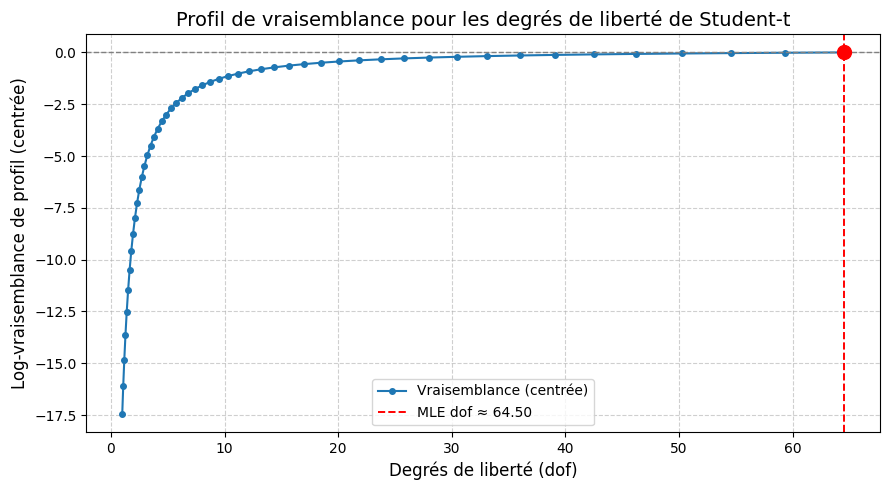

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def profile_likelihood_dof(df):
    df = df.dropna()

    js = np.arange(0, 51)
    dof_grid = np.exp(js / 12)

    loglik_values = []
    for dof in dof_grid:
        ll, _ = loglik_student_t(df, dof=dof)
        loglik_values.append(ll)

    loglik_values = np.array(loglik_values)
    ll_centered = loglik_values - loglik_values.max()

    idx_max = np.argmax(loglik_values)
    dof_mle = dof_grid[idx_max]

    print(f"EMV (dof) ≈ {dof_mle:.2f}")

    plt.figure(figsize=(9, 5))
    plt.plot(dof_grid, ll_centered, marker="o", markersize=4, linewidth=1.5,
             label="Vraisemblance (centrée)")
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.scatter(dof_mle, 0, color="red", s=100, zorder=5)
    plt.axvline(dof_mle, color="red", linestyle="--", linewidth=1.4,
                label=f"MLE dof ≈ {dof_mle:.2f}")

    plt.xlabel("Degrés de liberté (dof)", fontsize=12)
    plt.ylabel("Log-vraisemblance de profil (centrée)", fontsize=12)
    plt.title("Profil de vraisemblance pour les degrés de liberté de Student-t", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dof_grid, loglik_values, dof_mle

# Exemple d'appel
dof_grid, ll_vals, dof_mle = profile_likelihood_dof(df)


Problème 2 d est juste de l'interprétation